# Simple example using MLJ ensembling to construct a "self-tuning" random forest. 

In [50]:
# uncomment 2 lines for parallelized ensemble building:
# using Distributed
# addprocs()

using MLJ
using Plots
pyplot()
# load a task (data plus learning objective):
task = load_boston()
using Suppressor


Which models are available for this task?

In [51]:
models(task)

Dict{String,Any} with 3 entries:
  "MLJ"          => Any["DecisionTreeRegressor", "KNNRegressor", "RidgeRegresso…
  "DecisionTree" => Any["DecisionTreeRegressor"]
  "ScikitLearn"  => Any["SVMRegressor", "SVMLRegressor", "SVMNuRegressor"]

## EVALUATE A SINGLE TREE MODEL

In [52]:
@load DecisionTreeRegressor

┌ Info: A model named "DecisionTreeRegressor" is already loaded.
│ Nothing new loaded. 
└ @ MLJ /Users/vollmer/testgit/MLJ.jl/src/loading.jl:161


In [53]:
tree = DecisionTreeRegressor()
mach = machine(tree, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms,rmslp1])
# (MLJ.rms = 7.06, MLJ.rmslp1 = 0.33)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/vollmer/testgit/MLJ.jl/src/resampling.jl:90


(MLJ.rms = 7.06220240533269,
 MLJ.rmslp1 = 0.3277498771713516,)

## DEFINE THE RANDOM FOREST MODEL

In [54]:
forest = EnsembleModel(atom=tree)

MLJ.DeterministicEnsembleModel(atom = DecisionTreeRegressor @ 9…48,
                               weights = Float64[],
                               bagging_fraction = 0.8,
                               rng_seed = 0,
                               n = 100,
                               parallel = true,) @ 7…04

GET IDEA OF NUMBER OF TREES NEEDED

reduce number of features sampled at each nodes to sqrt of the
number of features, a common default:

In [55]:
tree.n_subfeatures = 3

# construct machine:
mach = machine(forest, task)

Machine @ 1…07


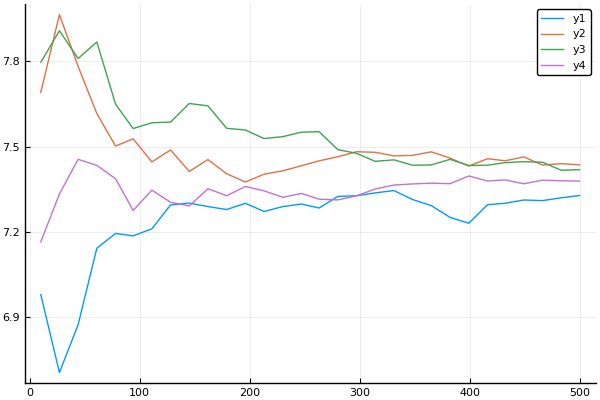

In [56]:
# range for forest.n:
r = range(forest, :n, lower=10, upper=500)

# generate learning curve, rms loss vs n:
curves = learning_curve!(mach, nested_range=(n=r,), measure=rms, n=4)
plot(curves.parameter_values, curves.measurements)

# Tuning

In [57]:
forest.n = 200

                     
## DEFINE A TUNING GRID

# inspect the nested hyperparameters of our composite model:
params(forest)

(atom = (pruning_purity_threshold = 0.0,
         max_depth = -1,
         min_samples_leaf = 5,
         min_samples_split = 2,
         min_purity_increase = 0.0,
         n_subfeatures = 3,
         post_prune = false,),
 weights = Float64[],
 bagging_fraction = 0.8,
 rng_seed = 0,
 n = 200,
 parallel = true,)

In [58]:
# define ranges for each parameter:
r1 = range(tree, :n_subfeatures, lower=1, upper=12)
r2 = range(forest, :bagging_fraction, lower=0.4, upper=1.0)

# define nested ranges, matching pattern of params(forest):
nested_ranges = (atom=(n_subfeatures=r1,), bagging_fraction=r2)


## WRAP THE MODEL IN A TUNING STRATEGY 
# creates a new "self-tuning" model!

tuning = Grid(resolution=12)
resampling = CV()
tuned_forest = TunedModel(model=forest, tuning=tuning, resampling=resampling,
                          nested_ranges=nested_ranges, measure=rms)

MLJ.DeterministicTunedModel(model = DeterministicEnsembleModel @ 7…04,
                            tuning = Grid @ 1…35,
                            resampling = CV @ 4…32,
                            measure = MLJ.rms,
                            operation = StatsBase.predict,
                            nested_ranges = (atom = (n_subfeatures = NumericRange @ 1…13,), bagging_fraction = NumericRange @ 1…09),
                            full_report = true,) @ 1…79

## EVALUATE THE SELF-TUNING RANDOM FOREST MODEL

In [59]:
mach = machine(tuned_forest, task)
evaluate!(mach, resampling=Holdout(fraction_train=0.8), measure=[rms, rmslp1], verbosity=2)
# (MLJ.rms = 4.09, MLJ.rmslp1 = 0.26)

┌ Info: Evaluating using a holdout set. 
│ fraction_train=0.8 
│ shuffle=false 
│ measure=Function[rms, rmslp1] 
│ operation=StatsBase.predict 
│ Resampling from all rows. 
└ @ MLJ /Users/vollmer/testgit/MLJ.jl/src/resampling.jl:90
┌ Info: Training Machine @ 1…96.
└ @ MLJ /Users/vollmer/testgit/MLJ.jl/src/machines.jl:97
Iterating over an 144-point grid: 100%[=========================] Time: 0:01:21
┌ Info: Training best model on all supplied data.
└ @ MLJ /Users/vollmer/testgit/MLJ.jl/src/tuning.jl:142


(MLJ.rms = 4.078641510675486,
 MLJ.rmslp1 = 0.25592200262008985,)

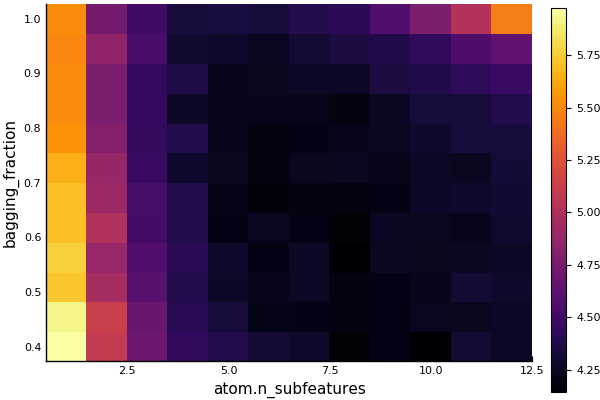

In [62]:
# Note that `evaluate!` has fitted `tuned_forest` on the training data
# (80% of all data), which means tuning the underlying `forest` (in
# this case using cross-validation) and then retraining `forest` on
# the full training data.

# We can view the optimal `forest` parameters:
fitted_params(mach)
fitted_params(mach).best_model


# And plot the performance estimates for the grid search:
@suppress heatmap(mach)